# Data Analysis Uber Pricing

Date: 24/05/2019


Environment: Python 3.6.5 and Anaconda Navigator 1.8.7



Libraries used:
* matplotlib.pyplot (for data exploration, included in Anaconda Python 3.6)
* pandas 0.19.2 (for data frame, included in Anaconda Python 3.6) 
* seaborn (for data exploration) 
* networkx (to calculate shortest distance in a network graph )
* datetime (to check for correct dates and days)
* numpy (for mathematical calculations)
* statsmodels.api (for multivariate regression)
* sklearn.ensemble (for classification using random forest)



## 1. Introduction
This notebook comprises cleaning the data for text analysis. Data cleaning is one of the most important and time consuming task that determines the quality of analysis in any process. The task helps us understand the three most common types of errors and tries to clean the data from those errors. The help us understand : 

1. Syntactical Anomalies: Errors that are genrally due to format and values of the data
2. Semantic Anomalies: Errors that are genrally due to comprehensiveness and non-redundancy in the data
3. Coverage Anomalies: Missing values in the data

More details for each task will be given in the following sections.

## 1. Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import networkx as nx
import datetime
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier

## 2. Loading the Dirty Data
The data used for this task is stored in 3 separate files. The data in `dirty_data`  contains dirty data that needs to be cleaned with the help of `edges` and `nodes` file.

In [2]:


uber_df = pd.read_csv("dirty_data.csv") 
edges_df = pd.read_csv("edges.csv")
nodes_df = pd.read_csv("nodes.csv")
flag = 0


## Exploratory Data Analysis

In [3]:
edges_df.head(5)

,Unnamed: 0,u,v,distance(m),street type,speed(km/h)
0,0,711327755,711332946,58.0,1,15.0
1,2,711327755,55725841,15.0,2,20.0
2,3,711327755,711327760,165.0,1,15.0
3,4,711327756,703557073,4.0,0,10.0
4,5,711327756,711332946,8.0,1,15.0


In [4]:
uber_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             286 non-null    object 
 1   Uber Type              286 non-null    int64  
 2   Origin Region          286 non-null    int64  
 3   Destination Region     286 non-null    int64  
 4   Origin Latitude        286 non-null    float64
 5   Origin Longitude       286 non-null    float64
 6   Destination Latitude   286 non-null    float64
 7   Destination Longitude  286 non-null    float64
 8   Journey Distance(m)    286 non-null    float64
 9   Departure Date         286 non-null    object 
 10  Departure Time         286 non-null    object 
 11  Travel Time(s)         286 non-null    float64
 12  Arrival Time           286 non-null    object 
 13  Fare$                  286 non-null    float64
dtypes: float64(7), int64(3), object(4)
memory usage: 31.4+ KB


In [5]:
uber_df.describe()

,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Travel Time(s),Fare$
count,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000
mean,0.779720,5.202797,4.884615,-36.524179,144.935533,-36.517425,144.943081,15095.083566,3973.013217,76.804580
std,0.751892,2.517474,2.551362,9.933529,0.103172,9.940136,0.099566,16014.661303,3895.919134,191.926104
min,0.000000,1.000000,1.000000,-38.110916,144.654173,-38.110916,144.654173,951.000000,217.140000,3.550000
25%,0.000000,3.000000,3.000000,-37.825318,144.927095,-37.822154,144.931905,5350.500000,1362.060000,11.150000
50%,1.000000,5.000000,5.000000,-37.815834,144.952894,-37.814889,144.966754,8791.000000,2437.800000,17.575000
75%,1.000000,7.000000,7.000000,-37.805933,144.988962,-37.805852,144.996657,12128.750000,3893.085000,29.495000
max,3.000000,9.000000,9.000000,37.861835,145.046450,38.110916,145.046450,51061.000000,13204.980000,1098.060000


Here viewing the description of the dataset in hand there are a few things that raise suspision 
* `Origin Latitude` : Max value is 37.86
* `Destination Latitude` : Max value is 38.11
Since the data is collected from `Victoria` itself, the latitude and longitude can not have a range as big as 60 degrees in terms or latitude. Therefore, it is definitely a type (Syntactical error)

Secondly, the time travel and fare value seems to have strange behaviour in terms of max value such as :
* The max `Time Travel` for some journey is 13204.98 seconds which is equal to 3.67 hours approx. Looking at the max `Journey Distance` travelled by any cab which is equal to 51 Km approx, it looks suspicious 
* Similary the `Fare` of 1098 dollars looks unreal for a `Ditance` of 51 km
The error in Time and Fare suggest some `Semantic Error`


## Preparing Data for further analysis

The data is split into smaller frangment to check for any errors or outliers.

In [6]:
dates =uber_df["Departure Date"].apply(lambda s:pd.Series({"Year":int(s.split("-")[0].strip()),"Month":int(s.split("-")[1].strip()),"Day":int(s.split("-")[2].strip())}))
departure_time = uber_df["Departure Time"].apply(lambda s:pd.Series({"Dep Hour":int(s.split(":")[0].strip()),"Dep Min":int(s.split(":")[1].strip()),"Dep Sec":int(s.split(":")[2].strip())}))
arrival_time = uber_df["Arrival Time"].apply(lambda s:pd.Series({"Arr Hour":int(s.split(":")[0].strip()),"Arr Min":int(s.split(":")[1].strip()),"Arr Sec":int(s.split(":")[2].strip())}))
uber_df = pd.concat([uber_df,dates,departure_time,arrival_time],axis=1)
uber_df["Arr Time"] = 0
uber_df["Dep Time"] = 0
uber_df["Time Taken"] = 0


In [7]:
for each_row in range(0,len(uber_df)):
    uber_df.at[each_row,"Arr Time"] = uber_df.loc[each_row]["Arr Hour"]*3600 + uber_df.loc[each_row]["Arr Min"]*60 + uber_df.loc[each_row]["Arr Sec"]
    uber_df.at[each_row,"Dep Time"] = uber_df.loc[each_row]["Dep Hour"]*3600 + uber_df.loc[each_row]["Dep Min"]*60 + uber_df.loc[each_row]["Dep Sec"]


(array([281.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   5.]),
 array([-38.1109156 , -30.51364055, -22.9163655 , -15.31909045,
         -7.7218154 ,  -0.12454035,   7.4727347 ,  15.07000975,
         22.6672848 ,  30.26455985,  37.8618349 ]),
 <a list of 10 Patch objects>)

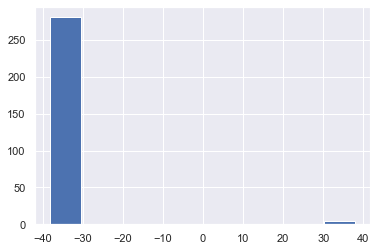

In [8]:
plt.hist(uber_df["Origin Latitude"])

Here we can see certain `outliers` in *Origin Latitudes*. The histogram helps us understand the spread really well. As the data us from Victoria the spread must not be high i.e. the range of values must be low which is not the case here. So definitely, there is an error. On closer inspection it is seen that it is a `Syntactical Anomaly`.

In [9]:
uber_df.loc[(uber_df["Origin Latitude"]>-25)]

,Unnamed: 0,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,...,Day,Dep Hour,Dep Min,Dep Sec,Arr Hour,Arr Min,Arr Sec,Arr Time,Dep Time,Time Taken
44,ID3229115650,1,5,1,37.799253,144.936490,-37.800238,144.969944,3189.0,2018-06-22,...,22,13,3,58,13,18,26,47906,47038,0
45,ID1124871665,0,6,2,37.787433,144.980377,-37.811397,144.937908,5953.0,2018-07-22,...,22,23,24,3,23,49,10,85750,84243,0
48,ID1413939448,0,2,3,37.814246,144.935278,-37.817427,144.987804,5409.0,2018-04-16,...,16,22,30,20,22,52,34,82354,81020,0
51,ID1717495513,0,6,7,37.790797,144.985865,-37.861835,144.905716,11711.0,2018-06-04,...,4,2,56,15,4,0,41,14441,10575,0
53,ID5989900523,2,7,3,37.861835,144.905716,-37.814862,144.974591,8450.0,2018-02-25,...,25,0,25,47,1,14,11,4451,1547,0


#### Fixing the anomalies

In [10]:
#uber_df.loc[(uber_df["Origin Region"] == 2)]["Origin Latitude"].value_counts()
#uber_df.loc[(uber_df["Origin Region"] == 7)]["Origin Latitude"].value_counts()
#uber_df.loc[(uber_df["Origin Region"] == 5)]["Origin Latitude"].value_counts()
uber_df.loc[(uber_df["Origin Region"] == 6)]["Origin Latitude"].value_counts()


-37.790797    9
-37.773803    7
-37.787433    6
-37.787442    6
-37.773845    3
 37.790797    1
 37.787433    1
Name: Origin Latitude, dtype: int64

In [11]:
uber_df.loc[(uber_df["Origin Latitude"]>-25),"Origin Latitude"] = -(uber_df.loc[(uber_df["Origin Latitude"])>-25]["Origin Latitude"])

(array([ 29.,   0.,   0.,   0.,   0.,   0.,   0.,  39., 124.,  94.]),
 array([-38.1109156, -38.0772043, -38.043493 , -38.0097817, -37.9760704,
        -37.9423591, -37.9086478, -37.8749365, -37.8412252, -37.8075139,
        -37.7738026]),
 <a list of 10 Patch objects>)

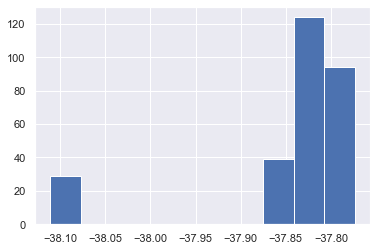

In [12]:
plt.hist(uber_df["Origin Latitude"])


## Checking for anomalies in Longitude

(array([29.,  0.,  0.,  0.,  0.,  0., 50., 74., 86., 47.]),
 array([144.6541725 , 144.69340025, 144.732628  , 144.77185575,
        144.8110835 , 144.85031125, 144.889539  , 144.92876675,
        144.9679945 , 145.00722225, 145.04645   ]),
 <a list of 10 Patch objects>)

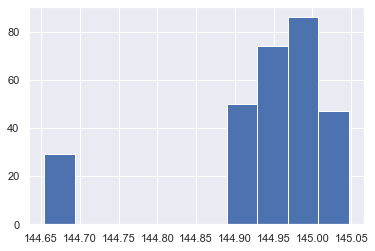

In [13]:
plt.hist(uber_df["Origin Longitude"])

## Checking for regional Boundries
Now that we have fixed the errors in latitude and longitude, we can check for regional boundries. We can do that using visuals from the scatter plot split by regions.

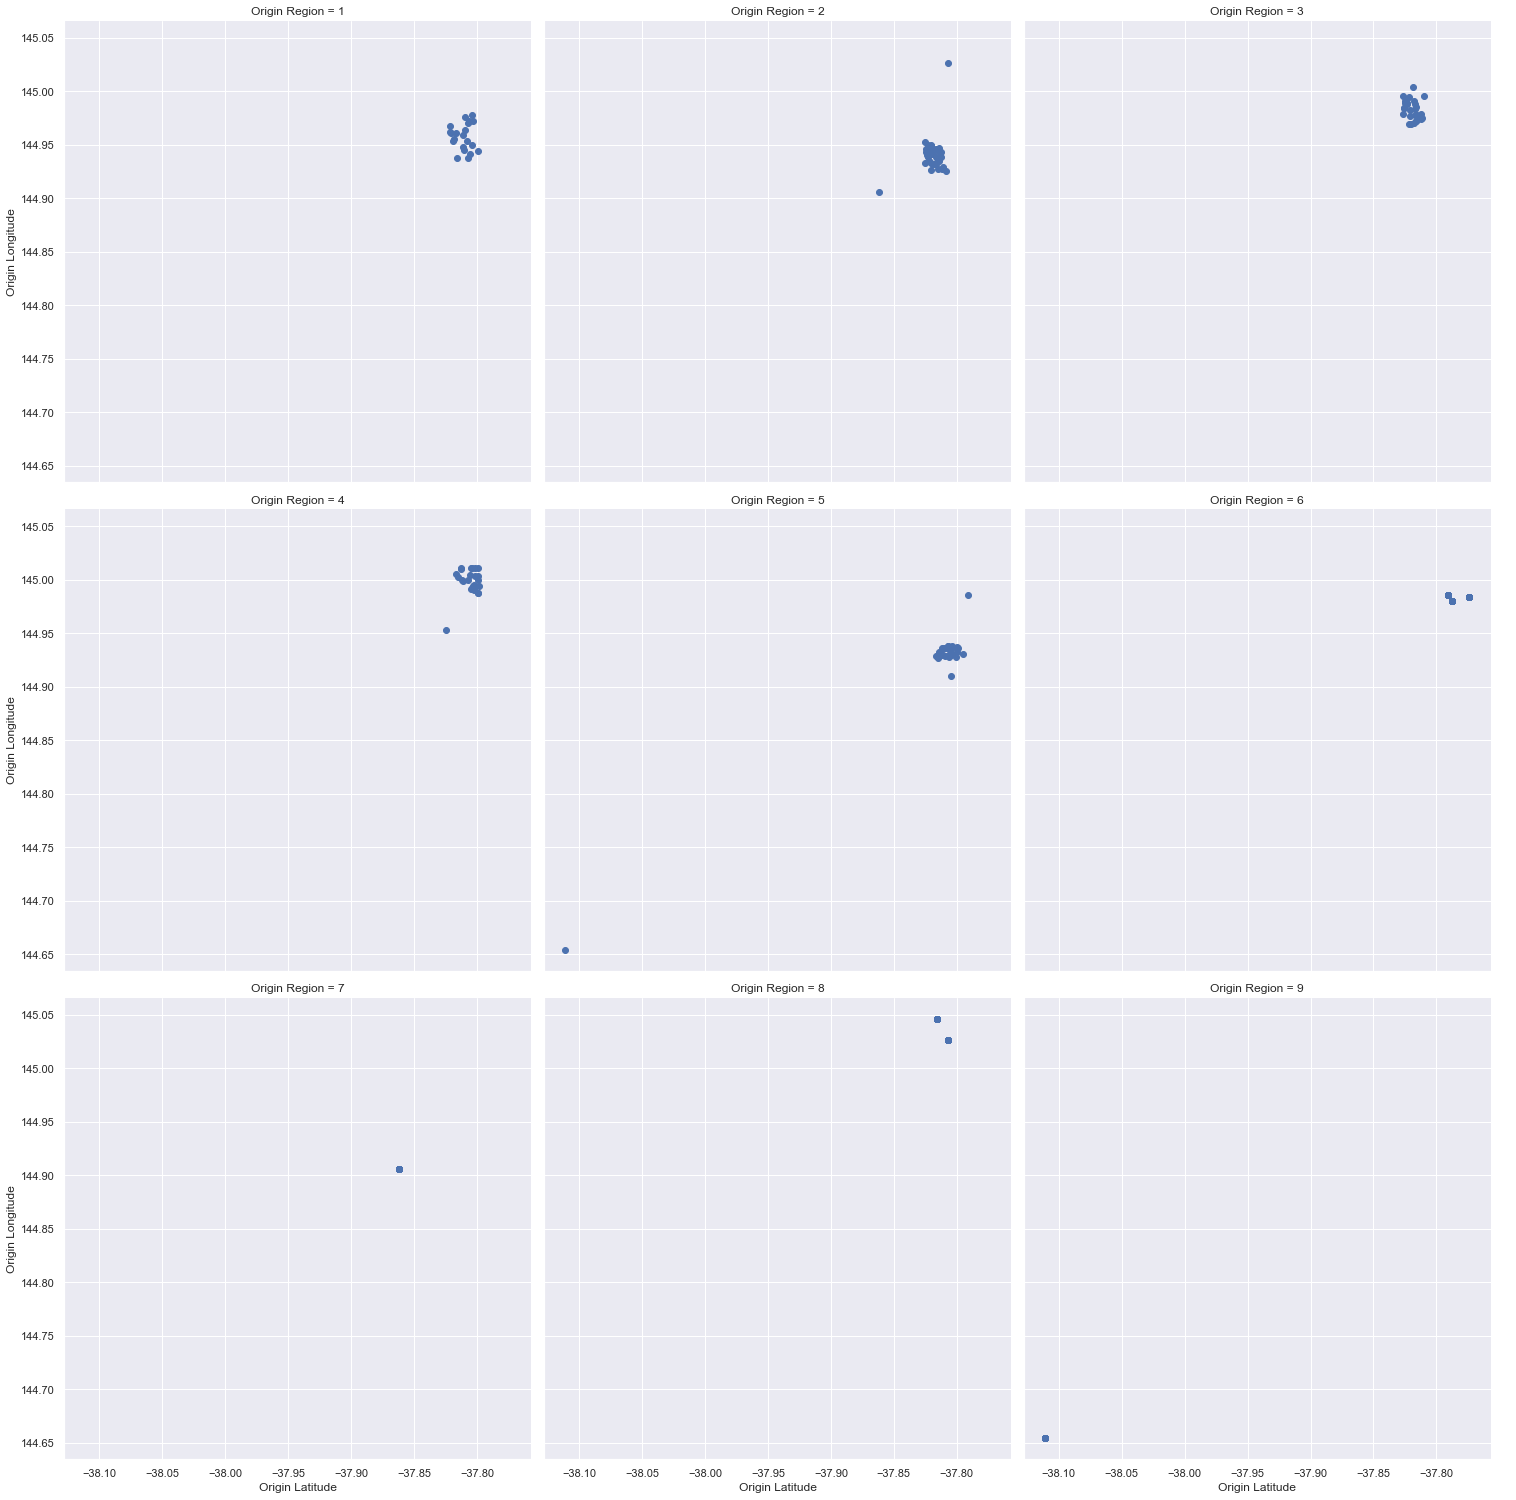

In [14]:
g = sns.FacetGrid(uber_df, col="Origin Region",col_wrap=3,height=7)
g.map(plt.scatter, "Origin Latitude", "Origin Longitude")
g.add_legend();


Here we can see some outliers in Region 2,4 and 5



## Fixing Regional Boundries

In [15]:
uber_df.loc[((uber_df["Origin Region"] ==2) & (uber_df["Origin Longitude"] >145)), "Origin Region"] = 8 
uber_df.loc[((uber_df["Origin Region"] ==2) & (uber_df["Origin Latitude"] <-37.85)),"Origin Region"] = 7 
uber_df.loc[((uber_df["Origin Region"] ==4) & (uber_df["Origin Longitude"] <144.97)),"Origin Region"] = 1  
uber_df.loc[((uber_df["Origin Region"] ==5) & (uber_df["Origin Longitude"] <144.7)),"Origin Region"] = 9 
uber_df.loc[((uber_df["Origin Region"] ==5) & (uber_df["Origin Longitude"] >144.95)),"Origin Region"] = 6

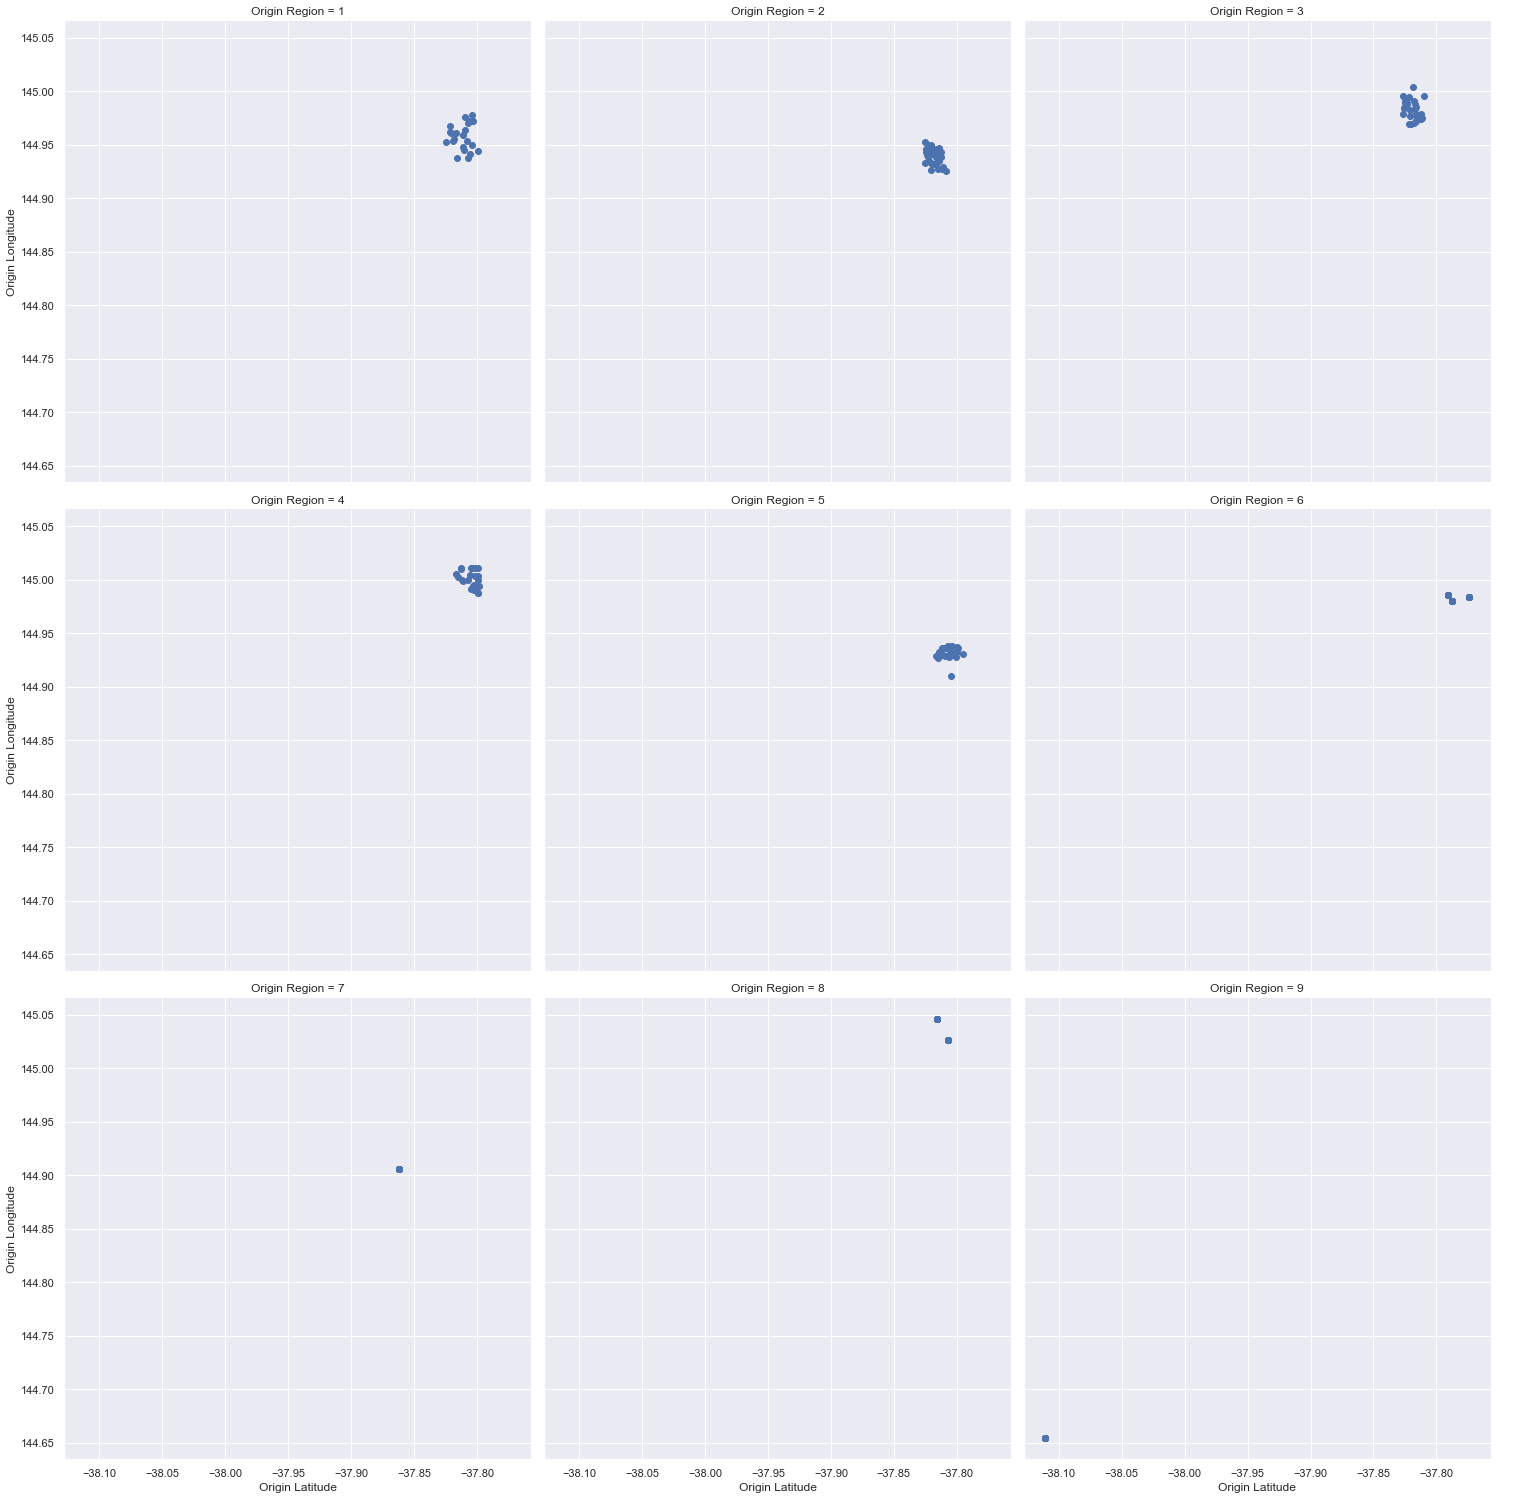

In [16]:
g = sns.FacetGrid(uber_df, col="Origin Region",col_wrap=3,height=7)
g.map(plt.scatter, "Origin Latitude", "Origin Longitude")
g.add_legend();

## Exploring and Fixing Destination Locations
Now that we have fixed error in origin region and geo locations we can follow the same step to fix errors in the destination regions and geo-locations

(array([281.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   5.]),
 array([-38.1109156 , -30.48873248, -22.86654936, -15.24436624,
         -7.62218312,   0.        ,   7.62218312,  15.24436624,
         22.86654936,  30.48873248,  38.1109156 ]),
 <a list of 10 Patch objects>)

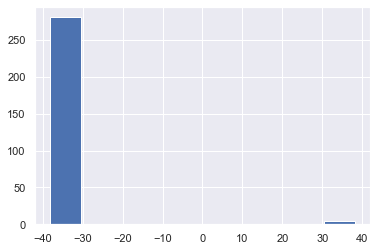

In [17]:
plt.hist(uber_df["Destination Latitude"])

Here in the histogram we can see an `outlier` which has values very different from the normal trend.

In [18]:
uber_df.loc[uber_df["Destination Latitude"] > -25]

,Unnamed: 0,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,...,Day,Dep Hour,Dep Min,Dep Sec,Arr Hour,Arr Min,Arr Sec,Arr Time,Dep Time,Time Taken
58,ID1487491204,0,5,4,-37.805918,144.936650,37.804986,144.995679,5757.0,2018-03-02,...,2,2,19,2,2,44,10,9850,8342,0
63,ID1503781776,0,7,5,-37.861835,144.905716,37.804481,144.936400,10830.0,2018-06-07,...,7,6,0,52,6,59,24,25164,21652,0
64,ID1172661954,0,9,5,-38.110916,144.654173,37.808375,144.928804,44129.0,2018-04-13,...,13,7,4,1,10,0,41,36041,25441,0
69,ID1302240018,0,3,9,-37.816735,144.988190,38.110916,144.654173,45704.0,2018-02-24,...,24,0,21,12,3,25,25,12325,1272,0
71,ID3675664533,1,7,8,-37.861835,144.905716,37.807202,145.026637,13986.0,2018-03-03,...,3,7,15,54,8,27,26,30446,26154,0


In [19]:
#uber_df.loc[(uber_df["Destination Region"] == 4)]["Destination Latitude"].value_counts()
#uber_df.loc[(uber_df["Destination Region"] == 5)]["Destination Latitude"].value_counts()
#uber_df.loc[(uber_df["Destination Region"] == 8)]["Destination Latitude"].value_counts()
uber_df.loc[(uber_df["Destination Region"] == 9)]["Destination Latitude"].value_counts()

-38.110916    24
 38.110916     1
Name: Destination Latitude, dtype: int64

In [20]:
uber_df.loc[(uber_df["Destination Latitude"]>-25),"Destination Latitude"] = -(uber_df.loc[(uber_df["Destination Latitude"])>-25]["Destination Latitude"])

(array([ 26.,   0.,   0.,   0.,   0.,   0.,   0.,  27., 144.,  89.]),
 array([-38.1109156, -38.0772043, -38.043493 , -38.0097817, -37.9760704,
        -37.9423591, -37.9086478, -37.8749365, -37.8412252, -37.8075139,
        -37.7738026]),
 <a list of 10 Patch objects>)

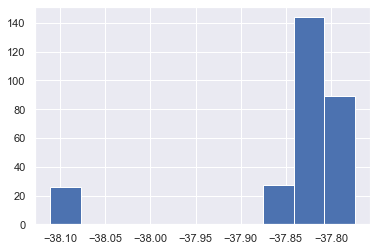

In [21]:
plt.hist(uber_df["Destination Latitude"])

(array([29.,  0.,  0.,  0.,  0.,  0., 50., 74., 86., 47.]),
 array([144.6541725 , 144.69340025, 144.732628  , 144.77185575,
        144.8110835 , 144.85031125, 144.889539  , 144.92876675,
        144.9679945 , 145.00722225, 145.04645   ]),
 <a list of 10 Patch objects>)

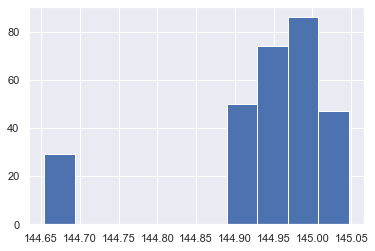

In [22]:
plt.hist(uber_df["Origin Longitude"])

### Checking for Reagional Boundraies (Destination) 

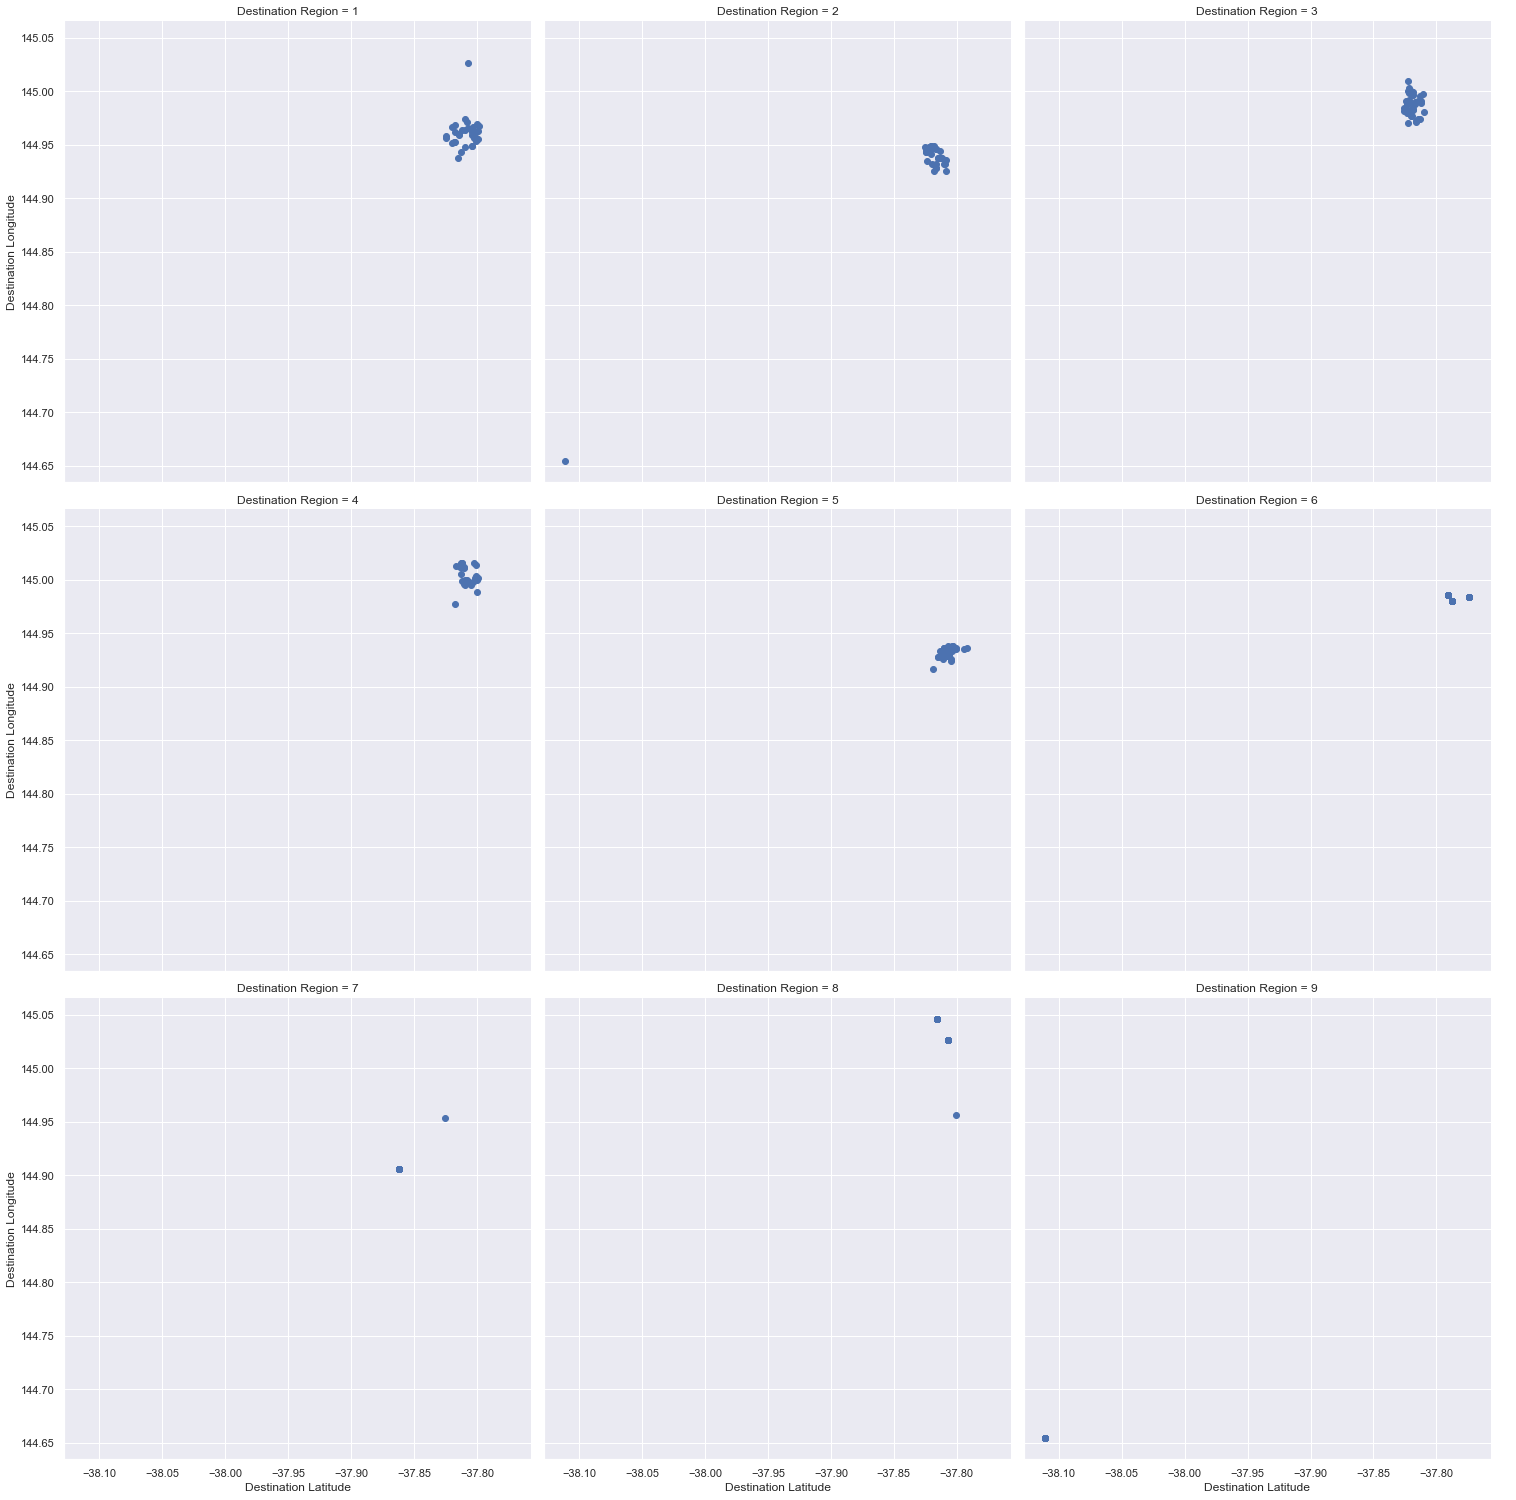

In [23]:
g = sns.FacetGrid(uber_df, col="Destination Region",col_wrap=3,height = 7)
g.map(plt.scatter, "Destination Latitude", "Destination Longitude")
g.add_legend();


Here also, we can see a few outliers in the Destination Regaions. We can fix them individually and assign them to their corresponding correct regions

In [24]:
uber_df.loc[((uber_df["Destination Region"] ==1) & (uber_df["Destination Longitude"] >145)), "Destination Region"] = 8 
uber_df.loc[((uber_df["Destination Region"] ==2) & (uber_df["Destination Latitude"] <-38.05)),"Destination Region"] = 9 
uber_df.loc[((uber_df["Destination Region"] ==7) & (uber_df["Destination Latitude"] >-37.85)),"Destination Region"] = 1 
uber_df.loc[((uber_df["Destination Region"] ==8) & (uber_df["Destination Longitude"] <145)),"Destination Region"] = 1 
uber_df.loc[((uber_df["Destination Region"] ==4) & (uber_df["Destination Longitude"] <144.98)),"Destination Region"] = 3 


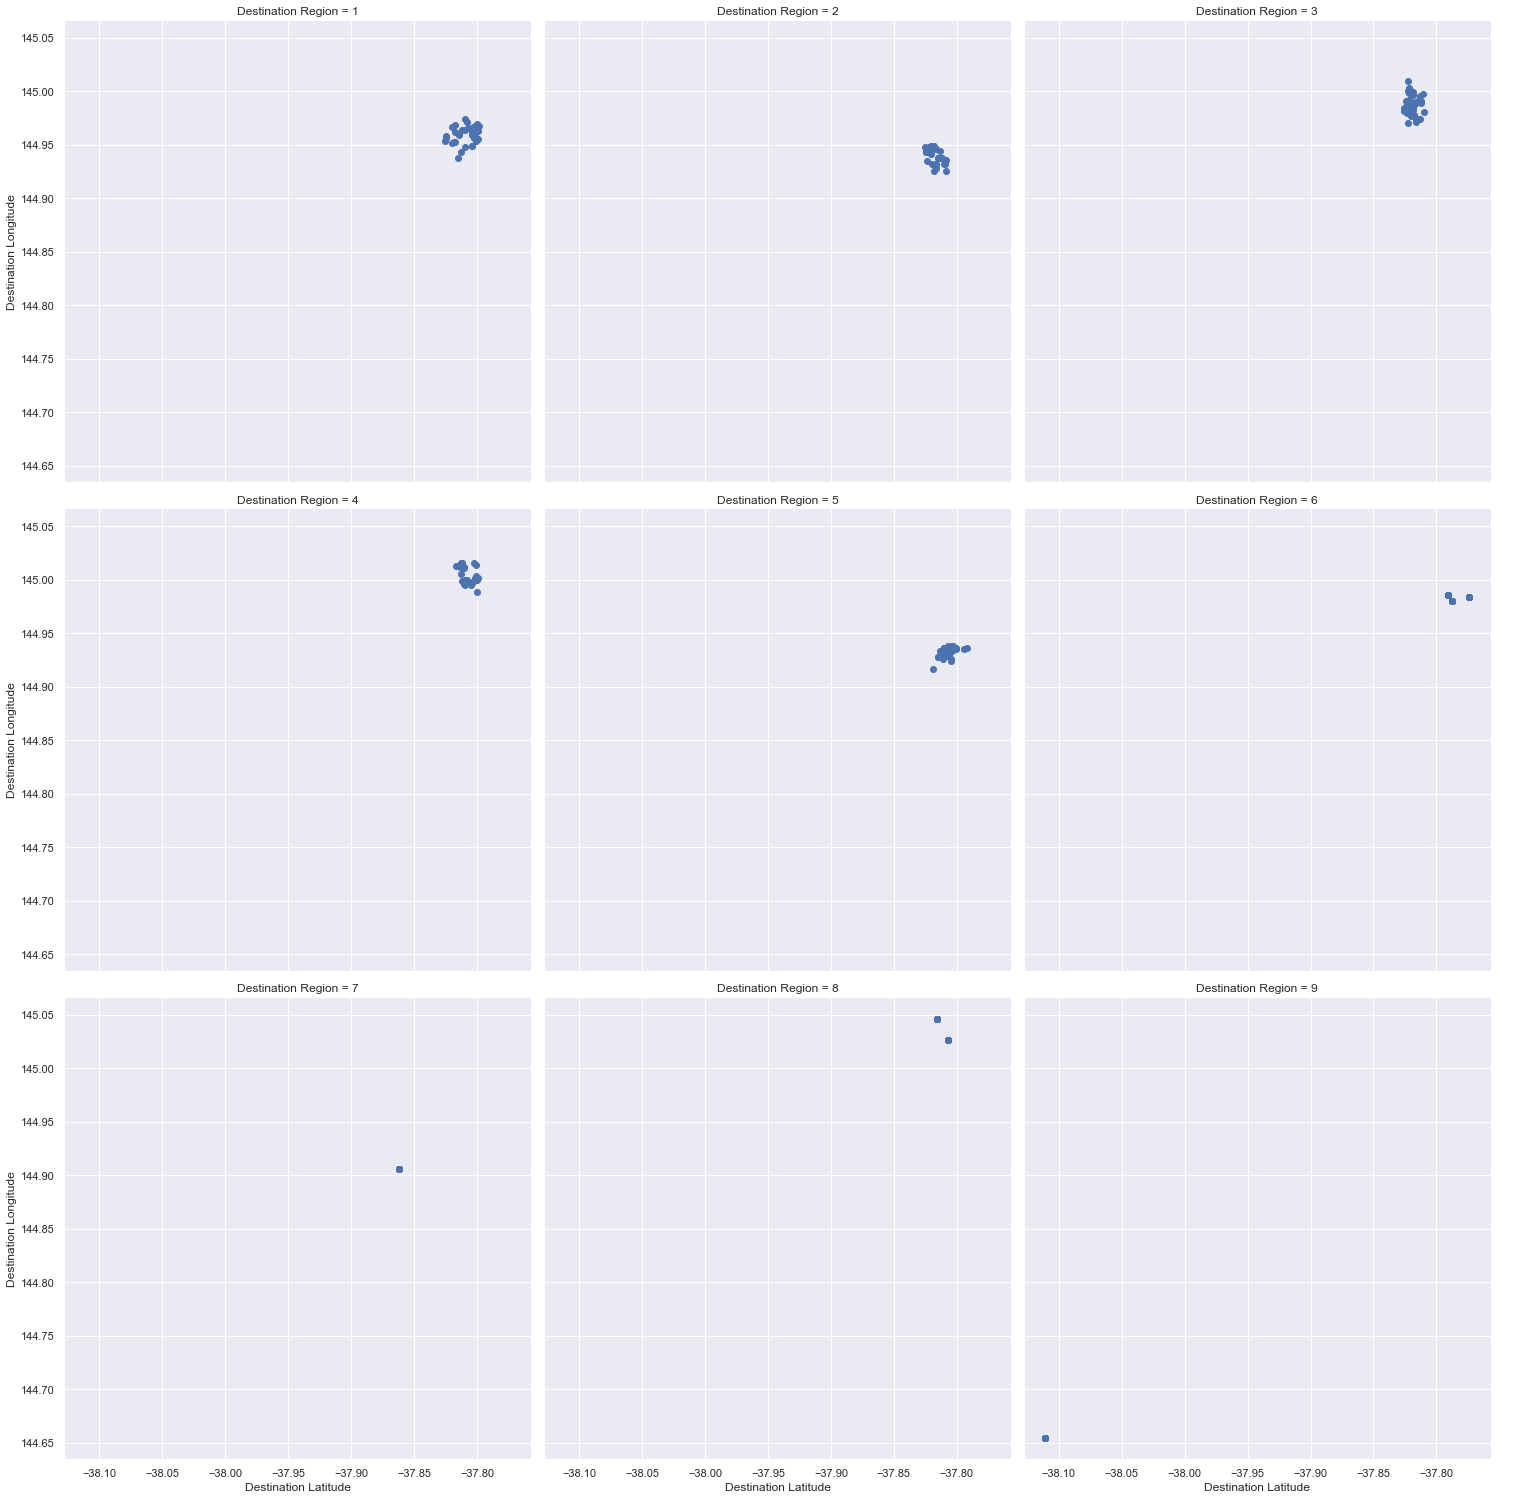

In [25]:
g = sns.FacetGrid(uber_df, col="Destination Region",col_wrap=3,height = 7)
g.map(plt.scatter, "Destination Latitude", "Destination Longitude")
g.add_legend();

## Checking for Errors in Distance and Time

As we are using diferent files to calculate the distance between two points we start by checking if every location in our data is present in the nodes file.

In [26]:
for each in uber_df["Origin Longitude"] :
    if each not in list(nodes_df.lon):
        print(each)


Now that we have checked for the nodes being present in the file, we can reduce the time complexity by filtering out only the data that is required to calculate the distance and the shortest path.

In [27]:
required_lat_nodes = pd.DataFrame(columns=nodes_df.columns.values)
required_nodes = pd.DataFrame(columns=nodes_df.columns.values)


In [28]:
for index,row in nodes_df.iterrows():
    if (row.lat in list(uber_df["Origin Latitude"])) or (row.lat in list(uber_df["Destination Latitude"])):
        required_lat_nodes = required_lat_nodes.append(pd.DataFrame(row).transpose())
for index,row in required_lat_nodes.iterrows():
    if (row.lon in list(uber_df["Origin Longitude"])) or (row.lon in list(uber_df["Destination Longitude"])):
        required_nodes = required_nodes.append(pd.DataFrame(row).transpose())

In [29]:
uber_df["Origin Node"] = 0
uber_df["Destination Node"] = 0

for index_u, row_u in uber_df.iterrows():
    lat_o = row_u["Origin Latitude"]
    lon_o = row_u["Origin Longitude"]
    lat_d = row_u["Destination Latitude"]
    lon_d = row_u["Destination Longitude"]
    for index_n, row in required_nodes.iterrows():
        if (lat_o == row.lat) & (lon_o == row.lon):
            node_o = required_nodes.loc[index_n,"Unnamed: 0"]
            break
    for index_n, row in required_nodes.iterrows():
        if (lat_d == row.lat) & (lon_d == row.lon):
            node_d = required_nodes.loc[index_n,"Unnamed: 0"]
            break
    
    uber_df.at[index_u,"Origin Node"] = node_o
    uber_df.at[index_u,"Destination Node"] = node_d

    


## Errors in Time

Here, we explore possibilities of errors in Arrival Time, Departure Time and Travel Time. For a few rows, It was notinced that the Departure Time was less than the arrival time which can never be the case incase of same day travel. We try to fix them by swapping values in such rows.

In [30]:
for index,row in uber_df.iterrows():
    if (row["Arr Time"] < row["Dep Time"]) & (row["Arr Hour"] > 2):
        uber_df.at[index,"Arr Hour"],uber_df.at[index,"Dep Hour"] = row["Dep Hour"],row["Arr Hour"]
        uber_df.at[index,"Arr Min"],uber_df.at[index,"Dep Min"] = row["Dep Min"],row["Arr Min"]
        uber_df.at[index,"Arr Sec"],uber_df.at[index,"Dep Sec"] = row["Dep Sec"],row["Arr Sec"]
        uber_df.at[index,"Arrival Time"],uber_df.at[index,"Departure Time"] = row["Departure Time"],row["Arrival Time"]

if flag == 0 : 
    uber_df.at[156,"Arrival Time"],uber_df.at[156,"Departure Time"] = uber_df.at[156,"Departure Time"],uber_df.at[156,"Arrival Time"] 
    uber_df.at[156,"Arr Hour"],uber_df.at[156,"Dep Hour"] = uber_df.at[156,"Dep Hour"],uber_df.at[156,"Arr Hour"]
    uber_df.at[156,"Arr Min"],uber_df.at[156,"Dep Min"] = uber_df.at[156,"Dep Min"],uber_df.at[156,"Arr Min"] 
    uber_df.at[156,"Arr Sec"],uber_df.at[156,"Dep Sec"] = uber_df.at[156,"Dep Sec"],uber_df.at[156,"Arr Sec"]
    flag = 1

In [31]:
for each_row in range(0,len(uber_df)):
    uber_df.at[each_row,"Arr Time"] = uber_df.loc[each_row]["Arr Hour"]*3600 + uber_df.loc[each_row]["Arr Min"]*60 + uber_df.loc[each_row]["Arr Sec"]
    uber_df.at[each_row,"Dep Time"] = uber_df.loc[each_row]["Dep Hour"]*3600 + uber_df.loc[each_row]["Dep Min"]*60 + uber_df.loc[each_row]["Dep Sec"]
    tt= uber_df.at[each_row,"Arr Time"]-uber_df.at[each_row,"Dep Time"]
    if tt<0:
        tt = ((23*3600 + 59*60 + 59) - uber_df.at[each_row,"Dep Time"]) + uber_df.at[each_row,"Arr Time"]
    uber_df.at[each_row,"Time Taken"] = tt
    

###### Now, that we have corrected the Syntactical Error we can check for a few `Semantical Errors`.
We can calculate the travel time by each uber drive and try to fing errors in related columns such as Arrival Time 

##### This may take 5-7 minutes to complete

In [32]:
uber_df["Distance"] = 0
uber_df["change"] = 0
cnt = 0
G = nx.from_pandas_edgelist(edges_df,"u","v",["distance(m)"])
for index,row in uber_df.iterrows():
    dist,path = nx.single_source_dijkstra(G,source=row["Origin Node"],target=row["Destination Node"],weight = "distance(m)")
    uber_df.loc[index,"Distance"] = dist
    if (uber_df.loc[index,"Time Taken"] > uber_df.loc[index,"Travel Time(s)"] + 1 ) | (uber_df.loc[index,"Time Taken"] < uber_df.loc[index,"Travel Time(s)"] -1 ):
        flag = 0 
        paths = nx.all_shortest_paths(G,source=row["Origin Node"], target=row["Destination Node"], weight="distance(m)",method = "dijkstra")
        p_list = list(paths)
        tt_list = list()
        for each_path in p_list:
            tt = 0
            for i in range(len(each_path)-1):
                tt = tt + (edges_df[((edges_df.u==each_path[i]) & (edges_df.v== each_path[i+1])) | ((edges_df.v==each_path[i]) & (edges_df.u== each_path[i+1]))]['distance(m)'].values[0] * 1.0 * 3600) / (edges_df[((edges_df.u==each_path[i]) & (edges_df.v== each_path[i+1])) | ((edges_df.v==each_path[i]) & (edges_df.u== each_path[i+1]))]['speed(km/h)'].values[0] * 1000)
            if (tt > uber_df.loc[index,"Travel Time(s)"] -5 ) & ( tt < uber_df.loc[index,"Travel Time(s)"] + 5 ):
                tt_list.append(tt)
        if len(tt_list) > 0 :
            tt = min(tt_list, key=lambda x:abs(x-uber_df.loc[index,"Travel Time(s)"]))
            uber_df.loc[index,"Time Taken"] = round(tt,2)
            uber_df.loc[index,"change"] = 1
        if len(p_list) == 1 :
            each_path = p_list[0]
            tt = 0
            for i in range(len(each_path)-1):
                tt = tt + (edges_df[((edges_df.u==each_path[i]) & (edges_df.v== each_path[i+1])) | ((edges_df.v==each_path[i]) & (edges_df.u== each_path[i+1]))]['distance(m)'].values[0] * 1.0 * 3600) / (edges_df[((edges_df.u==each_path[i]) & (edges_df.v== each_path[i+1])) | ((edges_df.v==each_path[i]) & (edges_df.u== each_path[i+1]))]['speed(km/h)'].values[0] * 1000)
            uber_df.loc[index,"Time Taken"] = round(tt,2)
            uber_df.loc[index,"change"] = 1
    else:
        uber_df.loc[index,"change"] = 2
    if uber_df.loc[index,"change"] ==0 :
        paths = nx.all_shortest_paths(G,source=row["Origin Node"], target=row["Destination Node"], weight="distance(m)",method = "dijkstra")
        p_list = list(paths)
        tt_list = list()
        for each_path in p_list:
            tt = 0
            for i in range(len(each_path)-1):
                tt = tt + (edges_df[((edges_df.u==each_path[i]) & (edges_df.v== each_path[i+1])) | ((edges_df.v==each_path[i]) & (edges_df.u== each_path[i+1]))]['distance(m)'].values[0] * 1.0 * 3600) / (edges_df[((edges_df.u==each_path[i]) & (edges_df.v== each_path[i+1])) | ((edges_df.v==each_path[i]) & (edges_df.u== each_path[i+1]))]['speed(km/h)'].values[0] * 1000)
            if (tt > uber_df.loc[index,"Time Taken"] - 5) & (tt < uber_df.loc[index,"Time Taken"] + 5):
                tt_list.append(tt)
        if len(tt_list)>0 :
            tt = min(tt_list, key=lambda x:abs(x-uber_df.loc[index,"Time Taken"]))
            uber_df.loc[index,"Time Taken"] = round(tt,2)
            uber_df.loc[index,"change"] = 1
        if len(p_list) == 1 :
            each_path = p_list[0]
            tt = 0
            for i in range(len(each_path)-1):
                tt = tt + (edges_df[((edges_df.u==each_path[i]) & (edges_df.v== each_path[i+1])) | ((edges_df.v==each_path[i]) & (edges_df.u== each_path[i+1]))]['distance(m)'].values[0] * 1.0 * 3600) / (edges_df[((edges_df.u==each_path[i]) & (edges_df.v== each_path[i+1])) | ((edges_df.v==each_path[i]) & (edges_df.u== each_path[i+1]))]['speed(km/h)'].values[0] * 1000)
            uber_df.loc[index,"Time Taken"] = round(tt,2)
            uber_df.loc[index,"change"] = 1

Here, we can try to rectify the `arrival time` of the cab based on departure time and the time taken by the cab on the shortest route. 

In [33]:
for index,row in uber_df.iterrows():
    a_time = row["Dep Time"] + int(row["Time Taken"])
    hour = (int(a_time/3600)%24)
    minutes = int((int(a_time)%3600)/60)
    seconds = int((int(a_time)%3600)%60)
    uber_df.at[index,"Arr Time"] = a_time 
    uber_df.at[index,"Arr Hour"] = hour
    uber_df.at[index,"Arr Min"] = minutes
    uber_df.at[index,"Arr Sec"] = seconds
    

In [34]:
uber_df["Arrival T"] = ""
for index,row in uber_df.iterrows():
    h = str(uber_df.at[index,"Arr Hour"])
    m = str(uber_df.at[index,"Arr Min"])
    if len(m) == 1:
        m = "0"+m
    s = str(uber_df.at[index,"Arr Sec"])
    if len(s) == 1:
        s = "0"+s
    uber_df.at[index,"Arrival T"] = h + ":" + m + ":" + s

### Finding errors in Dates
There are two different kinds of errors that are present in the dates
1. The days and Months were swapped
2. Few dates do not exist

In [35]:
for index,row in uber_df.iterrows():
    if row.Month > 12:
        temp = row.Month
        uber_df.at[index,"Month"] = uber_df.at[index,"Day"]
        uber_df.at[index,"Day"] = temp
    error = 0
    try : 
        datetime.datetime(int(row.Year),int(row.Month),int(row.Day))
    except ValueError :
        error = 1
    if error == 1:
        cnt+=1
        print(row["Departure Date"])



2018-23-07
2018-13-01
2018-21-04
2018-21-01
2018-24-03
2018-28-07
2018-04-31
2018-02-30
2018-02-30
2018-06-31
2018-02-30
2018-06-31
2018-02-30
2018-06-31
2018-02-30
2018-06-31


In [36]:
uber_df.loc[uber_df["Departure Date"]=="2018-02-30","Month"] = 3
uber_df.loc[uber_df["Departure Date"]=="2018-02-30","Day"] = 2
uber_df.loc[uber_df["Departure Date"]=="2018-04-31","Month"] = 5
uber_df.loc[uber_df["Departure Date"]=="2018-04-31","Day"] = 1
uber_df.loc[uber_df["Departure Date"]=="2018-06-31","Month"] = 7
uber_df.loc[uber_df["Departure Date"]=="2018-06-31","Day"] = 1


In [37]:
uber_df["Date"] = ""
for index,row in uber_df.iterrows():
    d = str(uber_df.at[index,"Day"])
    if len(d) == 1:
        d = "0"+d
    m = str(uber_df.at[index,"Month"])
    if len(m) == 1:
        m = "0"+m
    y = str(uber_df.at[index,"Year"])
    uber_df.at[index,"Date"] = y + "-" + m + "-" + d
    

Now that we have corrected the errors we now can overwrite the columns containing errors. 

In [38]:
uber_df["Journey Distance(m)"] = uber_df["Distance"] 
uber_df["Arrival Time"] = uber_df["Arrival T"] 
uber_df["Travel Time(s)"] = uber_df["Time Taken"] 
uber_df["Departure Date"] = uber_df["Date"] 

## Saving Dirty Data Solution

In [39]:
drop_col = ['Year','Month', 'Day', 'Dep Hour', 'Dep Min', 'Dep Sec', 'Arr Hour', 'Arr Min','Arr Sec', 'Arr Time', 'Dep Time', 'Time Taken', 'Origin Node','Destination Node', 'Distance', 'change', 'Arrival T', 'Date']
uber_df = uber_df.drop(drop_col,axis=1)


# Task II ( Outliers )
The second part of the assignment help us understand the concepts of outliers even better.

## Loading the outlier File

In [40]:
out_df = pd.read_csv("outliers.csv") 
remove_index = list()
out_df.describe()


,Unnamed: 0,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Travel Time(s),Fare$
count,91.00000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000
mean,45.00000,0.692308,5.362637,5.098901,-37.844442,144.941148,-37.848467,144.933487,16271.373626,4282.551429,64.761374
std,26.41338,0.678107,2.469892,2.426955,0.091211,0.104119,0.095384,0.105782,16158.807269,3856.152427,161.058180
min,0.00000,0.000000,1.000000,1.000000,-38.110916,144.654173,-38.110916,144.654173,1583.000000,400.740000,2.250000
25%,22.50000,0.000000,3.000000,3.000000,-37.824430,144.929256,-37.843803,144.915564,6051.500000,1553.340000,11.935000
50%,45.00000,1.000000,6.000000,5.000000,-37.815362,144.968872,-37.814837,144.969093,9561.000000,2945.580000,20.210000
75%,67.50000,1.000000,8.000000,7.000000,-37.806095,144.997805,-37.806255,144.991513,13774.000000,4245.270000,31.067500
max,90.00000,2.000000,9.000000,9.000000,-37.773803,145.046450,-37.773803,145.046450,51061.000000,13204.980000,886.910000


Since the fare of a drive is determined by a few factors that are not directly present in the file, we first try to calculate those measure that can helo us calculate the care and also determine the errors. The fare of a drive depends on :
1. The journey Distance
2. Departure Time
3. Uber Type ( Each uber type has its own model to calculate fare)
4. Day Type, weekend or weekday

In [41]:
out_df["Arr Time"] = 0
out_df["Dep Time"] = 0
out_df["Dep Group"] = 0

dates =out_df["Departure Date"].apply(lambda s:pd.Series({"Year":int(s.split("-")[0].strip()),"Month":int(s.split("-")[1].strip()),"Day":int(s.split("-")[2].strip())}))
departure_time = out_df["Departure Time"].apply(lambda s:pd.Series({"Dep Hour":int(s.split(":")[0].strip()),"Dep Min":int(s.split(":")[1].strip()),"Dep Sec":int(s.split(":")[2].strip())}))
arrival_time = out_df["Arrival Time"].apply(lambda s:pd.Series({"Arr Hour":int(s.split(":")[0].strip()),"Arr Min":int(s.split(":")[1].strip()),"Arr Sec":int(s.split(":")[2].strip())}))
out_df = pd.concat([out_df,dates,departure_time,arrival_time],axis=1)

for each_row in range(0,len(out_df)):
    arr_time = out_df.loc[each_row]["Arr Hour"]*3600 + out_df.loc[each_row]["Arr Min"]*60 + out_df.loc[each_row]["Arr Sec"]
    dep_time = out_df.loc[each_row]["Dep Hour"]*3600 + out_df.loc[each_row]["Dep Min"]*60 + out_df.loc[each_row]["Dep Sec"]
    
    out_df.at[each_row,"Arr Time"]  = arr_time
    out_df.at[each_row,"Dep Time"] = dep_time
    if (dep_time >= (3600 *6)) & (dep_time <= 11*3600 + 59*60 + 59 ):
        out_df.at[each_row,"Dep Group"] = 1
    elif (dep_time >= (3600 *12)) & (dep_time <= 20*3600 + 59*60 + 59 ):
        out_df.at[each_row,"Dep Group"] = 2
    else:
        out_df.at[each_row,"Dep Group"] = 3


out_df["Day Group"] = 1
for index,row in out_df.iterrows():
    journey_date = datetime.date(int(row.Year),int(row.Month),int(row.Day))
    if journey_date.weekday() >= 5:
        out_df.at[index,"Day Group"] = 2

## Model for Fare Calculation
Since the uber uses 3 different models to calculate the fare based on uber type we split the data in 3 different groups.

In [42]:
out_df0 = out_df.loc[out_df["Uber Type"] == 0]
out_df1 = out_df.loc[out_df["Uber Type"] == 1]
out_df2 = out_df.loc[out_df["Uber Type"] == 2]

To predict the price correctly we remove the irrelavant features to noise the variance in the models.

In [43]:
irrelavant_features = ['Unnamed: 0', 'Unnamed: 0.1', 'Uber Type', 'Origin Latitude', 'Origin Longitude','Destination Latitude', 'Destination Longitude',
       'Departure Date', 'Departure Time', 'Arr Time', 'Dep Time', 'Year','Arrival Time',
       'Dep Hour', 'Dep Min', 'Dep Sec', 'Arr Hour', 'Arr Min', 'Arr Sec','Travel Time(s)','Month', 'Day']
out_df0 = out_df0.drop(irrelavant_features,axis=1)
out_df1 = out_df1.drop(irrelavant_features,axis=1)
out_df2 = out_df2.drop(irrelavant_features,axis=1)


## Feature Selection

It is always better to check for features that have some correlation with the target.

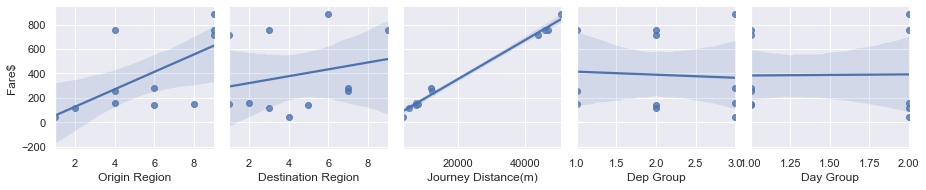

In [44]:
sns.pairplot(out_df2,x_vars=['Origin Region', 'Destination Region', 'Journey Distance(m)', 'Dep Group', 'Day Group'], y_vars=["Fare$"],kind="reg")


This module calculates the residuals of the predicted value and actual value. The residuals can be really helpful to find the outliers in the dataset.

In [45]:
def mod_data(df):
    y = df["Fare$"]
    X = df[['Origin Region', 'Destination Region', 'Journey Distance(m)', 'Dep Group', 'Day Group']]
    model = sm.OLS(y, X).fit()
    pred = model.predict(X)
    residuals = y-pred
    df["Residuals"] = residuals
    df["Prediction"] = pred
    return df

In [46]:
out_df0 = mod_data(out_df0)
out_df1 = mod_data(out_df1)
out_df2 = mod_data(out_df2)

## Residuals per Uber Type

### Uber Type 0

{'whiskers': [<matplotlib.lines.Line2D at 0x7fea5992dd00>,
 'caps': [<matplotlib.lines.Line2D at 0x7fea59aea400>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fea5992da60>],
 'medians': [<matplotlib.lines.Line2D at 0x7fea59aeaac0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fea59aeadc0>],
 'means': []}

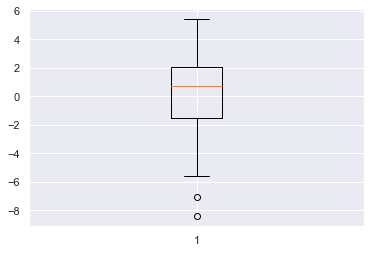

In [47]:
plt.boxplot(out_df0["Residuals"])

In [48]:
remove_index= list(out_df0[out_df0["Residuals"] < -6 ].index.values)

### Uber Type 1

{'whiskers': [<matplotlib.lines.Line2D at 0x7fea5eaf7a90>,
 'caps': [<matplotlib.lines.Line2D at 0x7fea5eafb190>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fea5eaf7730>],
 'medians': [<matplotlib.lines.Line2D at 0x7fea5eafb850>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fea5eafbb50>],
 'means': []}

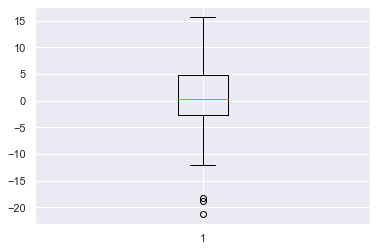

In [49]:
plt.boxplot(out_df1["Residuals"])

In [50]:
remove_index = remove_index + list(out_df1[out_df1["Residuals"] < -15].index.values)


### Uber Type 2

{'whiskers': [<matplotlib.lines.Line2D at 0x7fea59a855e0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fea59a85ca0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fea59a85280>],
 'medians': [<matplotlib.lines.Line2D at 0x7fea59a7b3a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fea59a7b6a0>],
 'means': []}

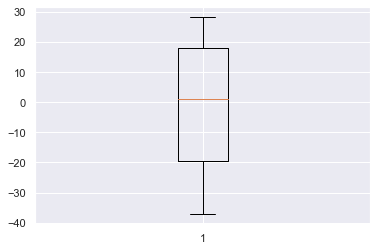

In [51]:
plt.boxplot(out_df2["Residuals"])

## Removing Outliers and Saving in a file

In [52]:
out_df = out_df.drop(out_df.index[remove_index])


In [53]:
drop_col = ['Arr Time', 'Dep Time', 'Dep Group', 'Year', 'Month', 'Day','Dep Hour', 'Dep Min', 'Dep Sec', 'Arr Hour', 'Arr Min', 'Arr Sec','Day Group']
out_df = out_df.drop(drop_col,axis=1)
out_df.to_csv("outliers_solution.csv",index = False)  

# Task III ( Missing Values )

In [54]:
miss_df = pd.read_csv("missing_value.csv") 
miss_df

,Unnamed: 0,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$
0,ID1417729091,0.0,2,4,-37.820624,144.941573,-37.800841,145.014854,7872.0,2018-01-15,22:17:23,2060.82,22:51:43,14.43
1,ID1349359534,NaN,8,7,-37.815834,145.046450,-37.861835,144.905716,15151.0,2018-07-28,13:32:58,4917.48,14:54:55,19.00
2,ID3511945378,NaN,1,4,-37.810523,144.976054,-37.816326,145.008887,3465.0,2018-01-24,15:17:22,862.98,15:31:44,14.74
3,ID1495524575,0.0,7,1,-37.861835,144.905716,-37.819885,144.957734,7953.0,2018-05-23,07:28:48,2775.96,8:15:03,8.82
4,ID3896182652,1.0,8,5,-37.815834,145.046450,-37.806770,144.932388,10380.0,2018-05-11,07:26:35,2930.82,8:15:25,17.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,ID1831741318,0.0,6,7,-37.790797,144.985865,-37.861835,144.905716,11711.0,2018-02-10,19:36:58,3866.94,20:41:24,19.01
98,ID1449000529,0.0,2,8,-37.824357,144.952343,-37.807202,145.026637,7943.0,2018-05-01,15:00:58,1998.60,15:34:16,9.65
99,ID1692595261,0.0,4,3,-37.799374,144.993186,-37.819312,145.006512,3245.0,2018-07-27,22:18:01,856.86,22:32:17,11.77
100,ID3820138785,1.0,1,9,-37.823181,144.960728,-38.110916,144.654173,43408.0,2018-07-07,06:45:43,10518.90,9:41:01,54.89


Since the fare of a drive is determined by a few factors that are not directly present in the file, we first try to calculate those measure that can helo us calculate the care and also determine the errors. The fare of a drive depends on :
1. The journey Distance
2. Departure Time
3. Uber Type ( Each uber type has its own model to calculate fare)
4. Day Type, weekend or weekday

In [55]:
miss_df["Arr Time"] = 0
miss_df["Dep Time"] = 0
miss_df["Dep Group"] = 0

dates =miss_df["Departure Date"].apply(lambda s:pd.Series({"Year":int(s.split("-")[0].strip()),"Month":int(s.split("-")[1].strip()),"Day":int(s.split("-")[2].strip())}))
departure_time = miss_df["Departure Time"].apply(lambda s:pd.Series({"Dep Hour":int(s.split(":")[0].strip()),"Dep Min":int(s.split(":")[1].strip()),"Dep Sec":int(s.split(":")[2].strip())}))
arrival_time = miss_df["Arrival Time"].apply(lambda s:pd.Series({"Arr Hour":int(s.split(":")[0].strip()),"Arr Min":int(s.split(":")[1].strip()),"Arr Sec":int(s.split(":")[2].strip())}))
miss_df = pd.concat([miss_df,dates,departure_time,arrival_time],axis=1)

for each_row in range(0,len(miss_df)):
    arr_time = miss_df.loc[each_row]["Arr Hour"]*3600 + miss_df.loc[each_row]["Arr Min"]*60 + miss_df.loc[each_row]["Arr Sec"]
    dep_time = miss_df.loc[each_row]["Dep Hour"]*3600 + miss_df.loc[each_row]["Dep Min"]*60 + miss_df.loc[each_row]["Dep Sec"]
    
    miss_df.at[each_row,"Arr Time"]  = arr_time
    miss_df.at[each_row,"Dep Time"] = dep_time
    if (dep_time >= (3600 *6)) & (dep_time <= 11*3600 + 59*60 + 59 ):
        miss_df.at[each_row,"Dep Group"] = 1
    elif (dep_time >= (3600 *12)) & (dep_time <= 20*3600 + 59*60 + 59 ):
        miss_df.at[each_row,"Dep Group"] = 2
    else:
        miss_df.at[each_row,"Dep Group"] = 3
        
        

In [56]:
miss_df["Day Group"] = 1
for index,row in miss_df.iterrows():
    journey_date = datetime.date(int(row.Year),int(row.Month),int(row.Day))
    if journey_date.weekday() >= 5:
        miss_df.at[index,"Day Group"] = 2

As 3 different ubertypes have 3 differnt models to calculate the fare we first start by splitting the data to create the models.


In [57]:
miss_df0 = miss_df.loc[miss_df["Uber Type"] == 0]
miss_df1 = miss_df.loc[miss_df["Uber Type"] == 1]
miss_df2 = miss_df.loc[miss_df["Uber Type"] == 2]

The module below is used to predict the fare of the drive based on selected features. The model after learning from the training data is used to predict the missing values.

In [58]:
def predict_fare(df):
    train = df[df["Fare$"].notna()]
    test = df[df["Fare$"].isna()]
    train_y = train["Fare$"]    
    train_X = train[['Origin Region', 'Destination Region', 'Journey Distance(m)', 'Dep Group', 'Day Group']]
    test_X = test[['Origin Region', 'Destination Region', 'Journey Distance(m)', 'Dep Group', 'Day Group']]
    model = sm.OLS(train_y, train_X).fit()
    pred = model.predict(test_X)
    for each in list(pred.index):
        miss_df.at[each,"Fare$"] = pred[each]
    
    
    

We create 3 models, one for each uber type to calculate the fare.

In [59]:
predict_fare(miss_df0)
predict_fare(miss_df1)
predict_fare(miss_df2)


Once we have the fare for every row, we can use that information to classify each drive into uber type. Here, we have used Random forest due to its high accuracy for classification problems.

In [60]:
train = miss_df[miss_df["Uber Type"].notna()]
train_y = train["Uber Type"]
train_x =  train[['Origin Region', 'Destination Region', 'Journey Distance(m)', 'Fare$','Dep Group', 'Day Group']]
test = miss_df[miss_df["Uber Type"].isna()]
test_x = test[['Origin Region', 'Destination Region', 'Journey Distance(m)', 'Fare$','Dep Group', 'Day Group']]
clf=RandomForestClassifier(n_estimators=100)
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(train_x,train_y)
y_pred=clf.predict(test_x)
test_x["prediction"] = y_pred

<ipython-input-60-1a2805502a75>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x["prediction"] = y_pred


In [61]:
for each in test_x.index:
    miss_df.at[each,"Uber Type"] = test_x.at[each,"prediction"]
    

## Saving Solution to a file 

In [62]:
#<student_no>.missing_value_solution.csv
drop_col = ['Arr Time', 'Dep Time', 'Dep Group', 'Year', 'Month', 'Day','Dep Hour', 'Dep Min', 'Dep Sec', 'Arr Hour', 'Arr Min', 'Arr Sec','Day Group']
miss_df = miss_df.drop(drop_col,axis=1)
miss_df.to_csv("missing_value_solution.csv",index = False)  



## Summary
The notebook gave a good understanding of the key concepts behind `Data Cleaning` such as dealing with
* Syntactical Anomalies: format and values
* Semantic Anomalies: comprehensiveness and non-redundancy
* Coverage Anomalies: missing values
* Not only this the assignment gave a hand on experience on data imputation using regression and classification which is similar to trend analysis. 